In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
import matplotlib.cm as cm
import cv2
from tensorflow.keras import backend as K
import time
from sklearn.metrics import accuracy_score

In [ ]:
import warnings   # 消除警告
warnings.filterwarnings("ignore")

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
config = ConfigProto()
config.allow_soft_placement=True
config.gpu_options.per_process_gpu_memory_fraction=0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Preparing data

In [ ]:
(x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = tf.image.grayscale_to_rgb(tf.expand_dims(x_train, axis=3))
x_test = tf.image.grayscale_to_rgb(tf.expand_dims(x_test, axis=3))

x_train = x_train.numpy()
x_test = x_test.numpy()

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')/255  # (60000, 28, 28, 3)
x_test = x_test.astype('float32')/255    # (10000, 28, 28, 3)
# Normalizing the RGB codes by dividing it to the max RGB value.

from sklearn.preprocessing import OneHotEncoder

Onehot = OneHotEncoder()
y_train = np.reshape(y_train, (-1,1))
Onehot.fit(y_train)
y_train = Onehot.transform(y_train).toarray()
y_test = Onehot.transform(np.reshape(y_test,(-1,1))).toarray()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
class Structure(tf.keras.Model):
    def __init__(self):
        super(Structure, self).__init__()
        
        ### Encoder Net
        self.enc_conv1 = Conv2D(32,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu',
                                name='enc_conv1')
        
        self.enc_pool1 = MaxPooling2D(pool_size=(2, 2), 
                                      name='enc_pool1')
        
        
        self.enc_conv2 = Conv2D(64,
                                kernel_size=(3, 3),
                                padding='same',
                                activation='relu',
                                name='enc_conv2')
        
        self.enc_pool2 = MaxPooling2D(pool_size=(2, 2), 
                                      name='enc_pool2')
        
        ### IDE model
        self.ide_flat = Flatten()
        
        self.ide_outputs = Dense(10, 
                                activation='softmax', 
                                name='ide_outputs')
        
        ### BCE model
        self.bce_dense1 = Dense(500, 
                                activation=LeakyReLU(alpha=0.3),
                                name='bce_dense1')
        
        self.bce_dense2 = Dense(100,  
                                activation=LeakyReLU(alpha=0.3),
                                name='bce_dense2')
        
        self.bce_dense3 = Dense(10, 
                                activation=LeakyReLU(alpha=0.3),
                                name='bce_dense3')
        
        self.bce_outputs = Dense(2, 
                                 activation='softmax',
                                 name='bce_outputs')
        
    def enc_model(self, x):              # (None, 28, 28, 3)
        z = self.enc_conv1(x)            # (None, 28, 28, 32)
        z = self.enc_pool1(z)            # (None, 14, 14, 32)
        z = self.enc_conv2(z)            # (None, 14, 14, 64)
        feat_ide_P2 = self.enc_pool2(z)  # (None, 7, 7, 64)
        return z, feat_ide_P2

    def ide_model(self, x):              # (None, 7, 7, 64)
        z = self.ide_flat(x)             # (None, 3136)
        z = self.ide_outputs(z)          # (None, 10)
        return z

    def bce_model(self, f_sub):                   # (None, 3136)
        z = LeakyReLU(alpha=0.3)(f_sub)           # (None, 3136)
        z = self.bce_dense1(z)                    # (None, 500)
        z = LeakyReLU(alpha=0.3)(z)   
        z = self.bce_dense2(z)                    # (None, 100)
        z = LeakyReLU(alpha=0.3)(z)  
        z = self.bce_dense3(z)                    # (None, 10)
        z = LeakyReLU(alpha=0.3)(z)  
        z = self.bce_outputs(z)                   # (None, 2)
        return z

    def call(self, inputs, **kwargs):
        z, fp = self.enc_model(inputs)
        pred_10 = self.ide_model(fp)
        
        _ = self.bce_model(tf.zeros([1, 3136])) # 建立但不用，做 gradcam 時會用到
        
        return pred_10, fp

In [ ]:
# Create Model
struc = Structure()
struc.build(input_shape=(1, 28, 28, 3))
struc.summary()

Model: "structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1 (Conv2D)           multiple                  896       
_________________________________________________________________
enc_pool1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
enc_conv2 (Conv2D)           multiple                  18496     
_________________________________________________________________
enc_pool2 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
ide_outputs (Dense)          multiple                  31370     
_________________________________________________________________
bce_dense1 (Dense)           multiple                  15

Train IDE

enc_conv1 >> trainable: True 

enc_pool1 >> trainable: False 

enc_conv2 >> trainable: True 

enc_pool2 >> trainable: False 

flatten >> trainable: False 

ide_outputs >> trainable: True 

bce_dense1 >> trainable: False 

bce_dense2 >> trainable: False 

bce_dense3 >> trainable: False 

bce_outputs >> trainable: False 

Model: "structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1 (Conv2D)           multiple                  896       
_________________________________________________________________
enc_pool1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
enc_conv2 (Conv2D)           multiple                  18496     
_________________________________________________________________
enc_pool2 (MaxPooling2D)     multiple                  0         
_________________________________________________________________

Text(0.5, 1.0, 'model loss IDE')

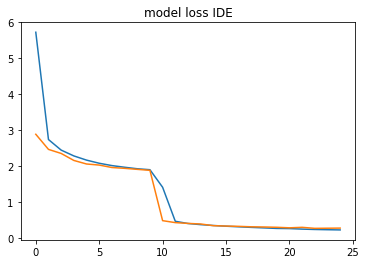

In [ ]:
from sklearn.metrics import accuracy_score
trainable_layers_name = ['enc_conv1', 'enc_conv2', 'ide_outputs']

for layer in struc.layers:
    if layer.name in trainable_layers_name:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f'{layer.name} >> trainable:', layer.trainable, '\n')

struc.summary()

optimizer_ide = Adam(1e-4)
checkpoint_ide = tf.train.Checkpoint(optimizer=optimizer_ide, model=struc)
loss_ide = CategoricalCrossentropy()

epochs = 25
batch_size = 100

train_datasets = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).shuffle(buffer_size=x_train.shape[0])
test_datasets = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size).shuffle(buffer_size=x_test.shape[0])

def IDE_train_step(x, y):
    with tf.GradientTape() as tape:
        pred, _ = struc(x)
        loss = loss_ide(pred, y)
    grads = tape.gradient(loss, struc.trainable_variables)
    optimizer_ide.apply_gradients(zip(grads, struc.trainable_variables))
    return loss, pred

def IDE_test_step(x, y):
    pred, _ = struc(x)
    loss = loss_ide(pred, y)
    return loss, pred

def IDE_train_step2(x, y):
    with tf.GradientTape() as tape:
        pred, _ = struc(x)
        loss = 1/loss_ide(pred, y)
    grads = tape.gradient(loss, struc.trainable_variables)
    optimizer_ide.apply_gradients(zip(grads, struc.trainable_variables))
    return loss, pred

def IDE_test_step2(x, y):
    pred, _ = struc(x)
    loss = 1/loss_ide(pred, y)
    return loss, pred
    
tr_L_avg = []
val_L_avg = []
for epoch in range(epochs):
    
    tr_L = []
    tr_Acc = []
    
    val_L = []
    val_Acc = []
    
    start = time.time()

    # train
    for image_batch, label_batch in train_datasets:
        loss, pred = IDE_train_step(image_batch, label_batch)
        acc = accuracy_score(tf.argmax(label_batch, 1), tf.argmax(pred, 1).numpy())
        tr_L.append(loss)
        tr_Acc.append(acc)

    # valdation
    for image_batch, label_batch in test_datasets:
        val_loss, val_pred = IDE_test_step(image_batch, label_batch)
        val_acc = accuracy_score(tf.argmax(label_batch, 1), tf.argmax(val_pred, 1).numpy())
        val_L.append(val_loss)
        val_Acc.append(val_acc)

    # show loss per epoch
    print('\nTime for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print('Train Loss: ', '%.4f' % np.mean(tr_L), 'Val Loss: ', '%.4f' % np.mean(val_L))
    print('Train Acc: ', '%.4f' % np.mean(tr_Acc), 'Val Acc: ', '%.4f' % np.mean(val_Acc))
    
    tr_L_avg.append(np.mean(tr_L))
    val_L_avg.append(np.mean(val_L))
    
plt.plot(tr_L_avg, label='Train')
plt.plot(val_L_avg, label='Val')
plt.title('model loss IDE')

Train IDE one more time with first 10k x_train_bar data  

Let grad-cam better then follow the paper


Time for epoch 1 is 2.5202414989471436 sec
Train Loss:  0.1713 Val Loss:  0.1175
Train Acc:  0.1247 Val Acc:  0.4083

Time for epoch 2 is 2.52793025970459 sec
Train Loss:  0.0988 Val Loss:  0.0895
Train Acc:  0.6278 Val Acc:  0.7195

Time for epoch 3 is 2.553009033203125 sec
Train Loss:  0.0843 Val Loss:  0.0808
Train Acc:  0.7614 Val Acc:  0.7937

Time for epoch 4 is 2.535728931427002 sec
Train Loss:  0.0782 Val Loss:  0.0759
Train Acc:  0.8239 Val Acc:  0.8558

Time for epoch 5 is 2.564023017883301 sec
Train Loss:  0.0745 Val Loss:  0.0731
Train Acc:  0.8710 Val Acc:  0.8884

Time for epoch 6 is 2.557925224304199 sec
Train Loss:  0.0725 Val Loss:  0.0716
Train Acc:  0.8920 Val Acc:  0.8969

Time for epoch 7 is 2.5290603637695312 sec
Train Loss:  0.0713 Val Loss:  0.0707
Train Acc:  0.8960 Val Acc:  0.8985

Time for epoch 8 is 2.524934768676758 sec
Train Loss:  0.0707 Val Loss:  0.0703
Train Acc:  0.8967 Val Acc:  0.8988

Time for epoch 9 is 2.5544776916503906 sec
Train Loss:  0.0703

Text(0.5, 1.0, 'model loss after 25 epochs')

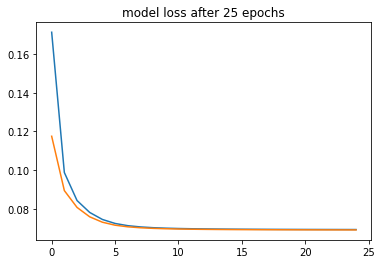

In [ ]:
def make_gradcam_heatmap(img_array):
    
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output, f = struc.enc_model(img_array)
        
        # Compute class predictions
        preds = struc.ide_model(f)
        
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:,top_pred_index]
        
    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

def img_bar(x_train=x_train):
    x_train_bar=[]
    for img in x_train[:10000]:
        img_array = img.reshape(1, 28, 28, 3)
        heatmap = make_gradcam_heatmap(img_array)
        heatmap = np.uint8(255 * heatmap)
        jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    #jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
        jet_heatmap = cv2.resize(jet_heatmap,(img.shape[1], img.shape[0]))

        beta = np.mean(jet_heatmap) 
        alpha = np.std(jet_heatmap)
        sigma = 1 /(1 + np.exp(-alpha*(jet_heatmap-beta)))
        img_bar = np.multiply(img, -(sigma-1)**3)
        x_train_bar.append(img_bar)
        
    x_train_bar = np.array(x_train_bar)
    return x_train_bar


x_train_bar = img_bar(x_train)
y_train_bar = y_train[:10000]

x_test_bar = img_bar(x_test)

train_bar_datasets = tf.data.Dataset.from_tensor_slices((x_train_bar, y_train_bar)).batch(batch_size).shuffle(buffer_size=x_train_bar.shape[0])
test_bar_datasets = tf.data.Dataset.from_tensor_slices((x_test_bar, y_test)).batch(batch_size).shuffle(buffer_size=x_test.shape[0])

tr_L_avg = []
val_L_avg = []
for epoch in range(epochs):
    tr_L = []
    tr_Acc = []
    
    val_L = []
    val_Acc = []
    
    start = time.time()

    # train
    for image_batch, label_batch in train_bar_datasets:
        loss, pred = IDE_train_step2(image_batch, label_batch)
        acc = 1-accuracy_score(tf.argmax(label_batch, 1), tf.argmax(pred, 1).numpy())
        tr_L.append(loss)
        tr_Acc.append(acc)

    # valdation
    for image_batch, label_batch in test_bar_datasets:
        val_loss, val_pred = IDE_test_step2(image_batch, label_batch)
        val_acc = 1-accuracy_score(tf.argmax(label_batch, 1), tf.argmax(val_pred, 1).numpy())
        val_L.append(val_loss)
        val_Acc.append(val_acc)
        
    # show loss per epoch
    print('\nTime for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print('Train Loss: ', '%.4f' % np.mean(tr_L), 'Val Loss: ', '%.4f' % np.mean(val_L))
    print('Train Acc: ', '%.4f' % np.mean(tr_Acc), 'Val Acc: ', '%.4f' % np.mean(val_Acc))
    
    tr_L_avg.append(np.mean(tr_L))
    val_L_avg.append(np.mean(val_L))

plt.plot(tr_L_avg, label='Train')
plt.plot(val_L_avg, label='Val')
plt.title('model loss after 25 epochs')

create data for bce

In [ ]:
y_train = np.argmax(y_train, axis=-1)

In [ ]:
#first 5000 pairs are same
#last 5000 pairs are diff
A=[]
B=[]
for i in range(10):
    idx = np.where(y_train == i)[0]
    np.random.shuffle(idx)
    for index1, index2 in zip(idx[:500],idx[-500:]):
        A.append(x_train[index1])
        B.append(x_train[index2])
A = np.array(A)
B = np.array(B)

In [ ]:
C=[]
D=[]
for i in range(10):
    idx   = np.where(y_train == i)[0]
    idx__ = np.where(y_train != i)[0]
    np.random.shuffle(idx)
    np.random.shuffle(idx__)
    for index1, index2 in zip(idx[:500],idx__[:500]):
        C.append(x_train[index1])
        D.append(x_train[index2])
C = np.array(C)
D = np.array(D)

In [ ]:
I1 = np.vstack((A,C))
I2 = np.vstack((B,D))

In [ ]:
first_5000 = np.ones(5000)
last_5000 = np.zeros(5000)
f_minus_label = np.hstack((first_5000, last_5000))

enc_conv1 >> trainable: False 

enc_pool1 >> trainable: False 

enc_conv2 >> trainable: False 

enc_pool2 >> trainable: False 

flatten >> trainable: False 

ide_outputs >> trainable: False 

bce_dense1 >> trainable: True 

bce_dense2 >> trainable: True 

bce_dense3 >> trainable: True 

bce_outputs >> trainable: True 

Model: "structure"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_conv1 (Conv2D)           multiple                  896       
_________________________________________________________________
enc_pool1 (MaxPooling2D)     multiple                  0         
_________________________________________________________________
enc_conv2 (Conv2D)           multiple                  18496     
_________________________________________________________________
enc_pool2 (MaxPooling2D)     multiple                  0         
_________________________________________________________________


Text(0.5, 1.0, 'model loss bce')

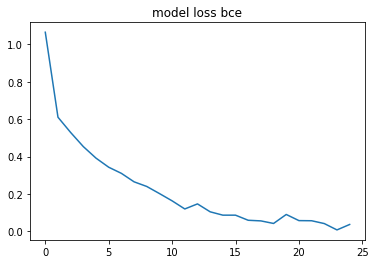

In [ ]:
trainable_layers_name = ['bce_dense1', 'bce_dense2', 'bce_dense3', 'bce_outputs']

for layer in struc.layers:
    if layer.name in trainable_layers_name:
        layer.trainable = True
    else:
        layer.trainable = False
    print(f'{layer.name} >> trainable:', layer.trainable, '\n')

struc.summary()

optimizer_bce = Adam()
checkpoint_bce = tf.train.Checkpoint(optimizer=optimizer_bce, model=struc)
loss_bce = SparseCategoricalCrossentropy()

epochs = 25
batch_size = 50

train_datasets = tf.data.Dataset.from_tensor_slices((I1, I2, f_minus_label)).batch(batch_size).shuffle(buffer_size=I1.shape[0])

def BCE_train_step(x, y):
    with tf.GradientTape() as tape:
        _, f1 = struc.enc_model(x[0])
        _, f2 = struc.enc_model(x[1])
        fsub = tf.math.subtract(f1, f2)
        fsub = tf.reshape(fsub, [fsub.get_shape()[0], 3136])
        pred = struc.bce_model(fsub)
        loss = loss_bce(y, pred)
    grads = tape.gradient(loss, struc.trainable_variables)
    optimizer_bce.apply_gradients(zip(grads, struc.trainable_variables))
    return loss, pred

tr_L_avg = []
for epoch in range(epochs):
    tr_L = []
    tr_Acc = []
    
    start = time.time()

    # train
    for x1_batch, x2_batch, label_batch in train_datasets:
        loss, pred = BCE_train_step([x1_batch, x2_batch], label_batch)
        acc = accuracy_score(label_batch, tf.argmax(pred, 1).numpy())
        tr_L.append(loss)
        tr_Acc.append(acc)
     
    # show loss per epoch
    print('\nTime for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    print('Train Loss: ', '%.4f' % np.mean(tr_L))
    print('Train Acc: ', '%.4f' % np.mean(tr_Acc))
    
    tr_L_avg.append(np.mean(tr_L))

plt.plot(tr_L_avg, label='Train')
plt.title('model loss bce')

Testing result (3rd time with bce)

In [ ]:
def bce_gradcam_heatmap(img1,img2):
    
    max_pool_2d = MaxPooling2D(pool_size=(2, 2))

    with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
        
        with tf.GradientTape() as tape:
            
            A1, _ = struc.enc_model(np.reshape(img1, (1, 28, 28, 3)))
            A2, _ = struc.enc_model(np.reshape(img2, (1, 28, 28, 3)))
            
            f1 = max_pool_2d(A1)
            f2 = max_pool_2d(A2)
            
            f1 = tf.reshape(f1, [1, -1])
            f2 = tf.reshape(f2, [1, -1])
            
            fsub = tf.math.subtract(f1, f2)
            
            # Compute class predictions
            preds = struc.bce_model(fsub)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:,top_pred_index]

        # This is the gradient of the top predicted class with regard to
        # the output feature map of the last conv layer
        grads = tape.gradient(top_class_channel, fsub)   #partial z/ partial f-
        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        grads = grads.numpy()
        alpha = np.zeros(grads.shape[1])
        for i in range(grads.shape[1]):
                alpha[i] = tf.math.reduce_max([0, grads[0][i]]) 
        alpha = np.reshape(alpha,(1, 3136))        

        s1 = Dot(axes=1)([alpha, f1])
        s2 = Dot(axes=1)([alpha, f2])
           
    alpha1 = tape1.gradient(s1,A1)
    alpha2 = tape2.gradient(s2,A2)

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class

    alpha1 = GlobalAveragePooling2D()(alpha1)
    alpha2 = GlobalAveragePooling2D()(alpha2)

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap1 = np.mean(A1, axis=-1)
    heatmap2 = np.mean(A2, axis=-1)
    
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap1 = np.maximum(heatmap1, 0) / np.max(heatmap1)
    heatmap2 = np.maximum(heatmap2, 0) / np.max(heatmap2)
    return heatmap1, heatmap2

In [ ]:
heatmap1, heatmap2 = bce_gradcam_heatmap(x_train[12], x_train[4471])

array([[[0.01204427, 0.01580346, 0.01580346, 0.01580346, 0.01580346,
         0.01580346, 0.01580346, 0.01580346, 0.01580346, 0.01580346,
         0.01580346, 0.01580346, 0.01580346, 0.01205971],
        [0.06149691, 0.16191146, 0.21797836, 0.25379843, 0.2581301 ,
         0.2483205 , 0.22877222, 0.18625756, 0.12821192, 0.06446206,
         0.02313232, 0.02007178, 0.02007178, 0.01481536],
        [0.21610723, 0.50618017, 0.6490752 , 0.7318131 , 0.7415058 ,
         0.7110098 , 0.70404965, 0.64419824, 0.46512064, 0.2917297 ,
         0.10440569, 0.02007178, 0.02007178, 0.01481536],
        [0.27673542, 0.70707744, 0.86543775, 0.9174268 , 0.90216225,
         0.85878074, 0.8475787 , 0.87986916, 0.724088  , 0.49719837,
         0.18810067, 0.02007178, 0.02007178, 0.01481536],
        [0.27326876, 0.6250305 , 0.7710245 , 0.83777255, 0.7838581 ,
         0.7144972 , 0.62838155, 0.71050406, 0.7784972 , 0.5778367 ,
         0.21125792, 0.02007178, 0.02007178, 0.01481536],
        [0.10821917,

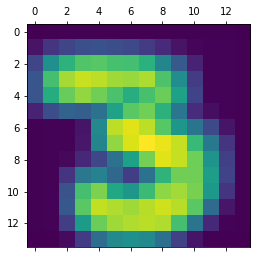

In [ ]:
plt.matshow(heatmap1[0])
heatmap1

array([[[0.01242818, 0.0163072 , 0.0163072 , 0.0163072 , 0.0163072 ,
         0.0163072 , 0.0163072 , 0.0163072 , 0.0163072 , 0.0163072 ,
         0.0163072 , 0.0163072 , 0.0163072 , 0.01244412],
        [0.01560757, 0.0216377 , 0.0401177 , 0.07091544, 0.08324426,
         0.0868536 , 0.06804369, 0.04537946, 0.02163315, 0.02071158,
         0.02071158, 0.02071158, 0.02071158, 0.01528761],
        [0.06242817, 0.21601145, 0.33641902, 0.44017437, 0.49183574,
         0.4959655 , 0.42901203, 0.29101968, 0.17435177, 0.04710779,
         0.02071158, 0.02071158, 0.02071158, 0.01528761],
        [0.21764812, 0.535294  , 0.72667295, 0.842906  , 0.8922299 ,
         0.9054746 , 0.8869015 , 0.63963616, 0.39223504, 0.1315788 ,
         0.02071158, 0.02071158, 0.02071158, 0.01528761],
        [0.272392  , 0.6771271 , 0.8385644 , 0.864521  , 0.84010684,
         0.7720919 , 0.7966454 , 0.7422678 , 0.48840934, 0.16275108,
         0.02042527, 0.02071158, 0.02071158, 0.01528761],
        [0.26564735,

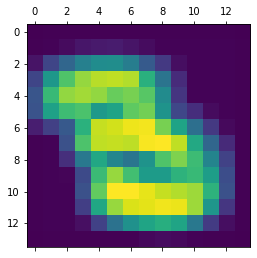

In [ ]:
plt.matshow(heatmap2[0])
heatmap2

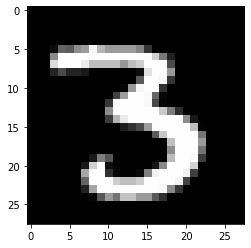

In [ ]:
plt.imshow(x_train[12])

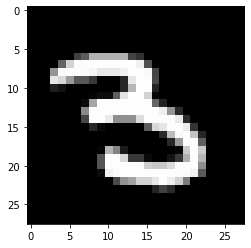

In [ ]:
plt.imshow(x_train[4471])

In [ ]:
I2.shape

(10000, 28, 28, 3)